In [13]:
!pip install opencv-contrib-python scikit-image matplotlib



   ---------------------------------------- 0.0/46.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/46.2 MB ? eta -:--:--
   ---------------------------------------- 0.5/46.2 MB 1.1 MB/s eta 0:00:43
   ---------------------------------------- 0.5/46.2 MB 1.1 MB/s eta 0:00:43
    --------------------------------------- 0.8/46.2 MB 887.3 kB/s eta 0:00:52
   - -------------------------------------- 1.3/46.2 MB 1.3 MB/s eta 0:00:36
   - -------------------------------------- 1.8/46.2 MB 1.5 MB/s eta 0:00:30
   -- ------------------------------------- 2.9/46.2 MB 2.0 MB/s eta 0:00:22
   --- ------------------------------------ 3.7/46.2 MB 2.3 MB/s eta 0:00:19
   ---- ----------------------------------- 5.0/46.2 MB 2.8 MB/s eta 0:00:15
   ----- ---------------------------------- 6.3/46.2 MB 3.2 MB/s eta 0:00:13
   ----- ---------------------------------- 6.6/46.2 MB 3.1 MB/s eta 0:00:13
   ------ --------------------------------- 7.3/46.2 MB 3.1 MB/s eta 0:00:13
   ------- 

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Sanmitha S Shetty\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages\\cv2\\cv2.pyd'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


BRISQUE model files not found. Skipping BRISQUE score.
BRISQUE model files not found. Skipping BRISQUE score.
Image: h1
  BRISQUE (lower is better): original=None, final=None
  Entropy: original=7.28, final=7.55
  Contrast (std): original=67.32, final=67.92



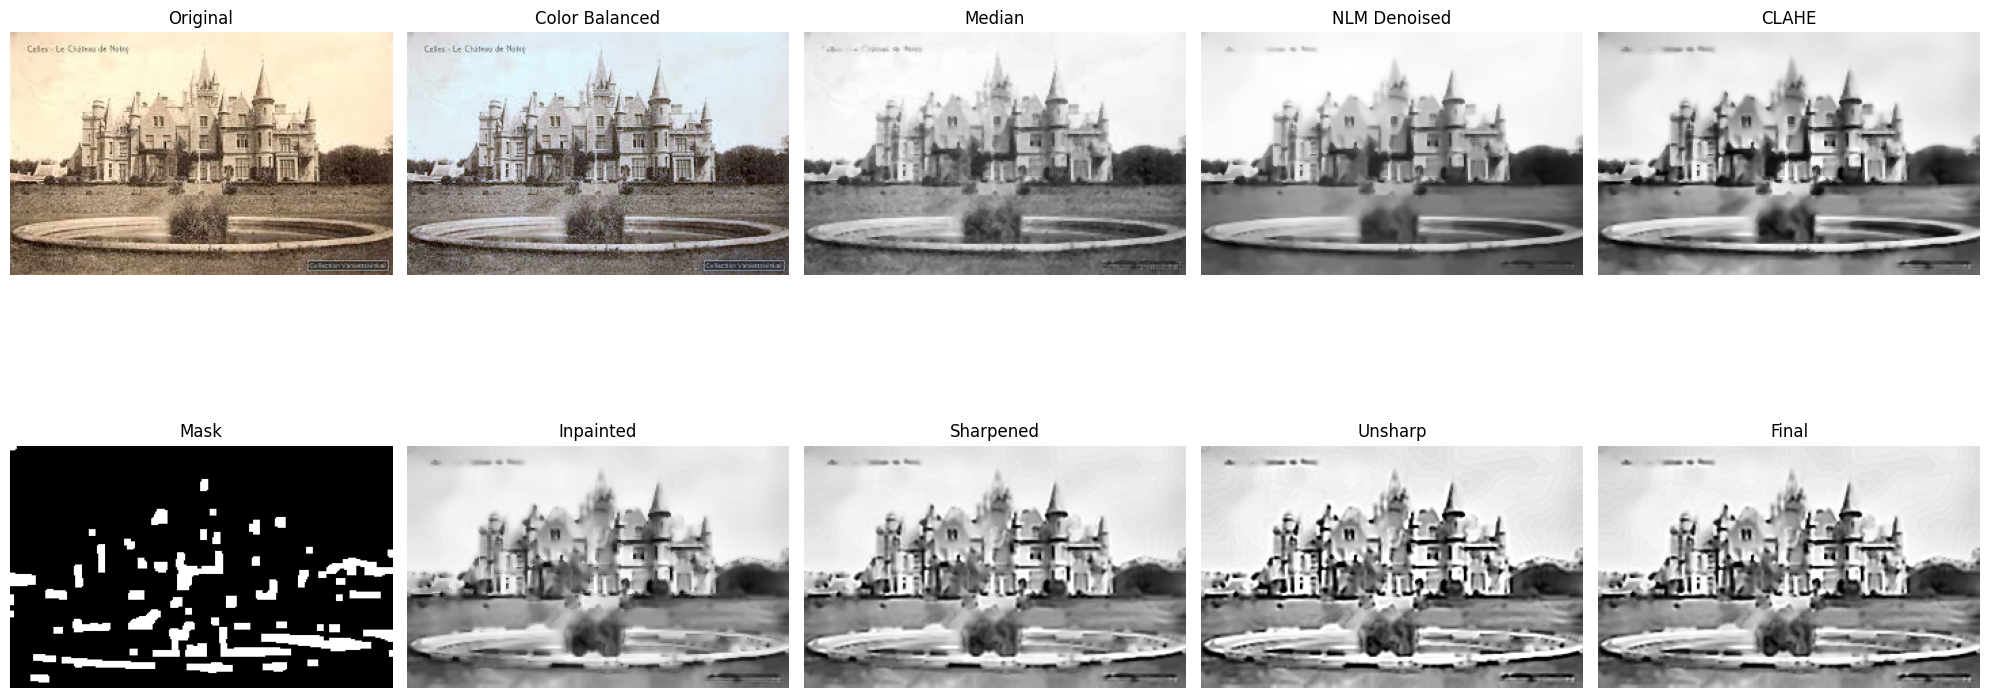

BRISQUE model files not found. Skipping BRISQUE score.
BRISQUE model files not found. Skipping BRISQUE score.
Image: h10
  BRISQUE (lower is better): original=None, final=None
  Entropy: original=7.72, final=7.93
  Contrast (std): original=65.14, final=71.44

BRISQUE model files not found. Skipping BRISQUE score.
BRISQUE model files not found. Skipping BRISQUE score.
Image: h11
  BRISQUE (lower is better): original=None, final=None
  Entropy: original=6.04, final=6.14
  Contrast (std): original=94.53, final=93.01

BRISQUE model files not found. Skipping BRISQUE score.
BRISQUE model files not found. Skipping BRISQUE score.
Image: h12
  BRISQUE (lower is better): original=None, final=None
  Entropy: original=6.92, final=6.85
  Contrast (std): original=40.93, final=40.56

BRISQUE model files not found. Skipping BRISQUE score.
BRISQUE model files not found. Skipping BRISQUE score.
Image: h13
  BRISQUE (lower is better): original=None, final=None
  Entropy: original=6.52, final=6.73
  Contr

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from skimage.measure import shannon_entropy

# === CONFIGURATION ===
image_folder = r"C:\Users\Sanmitha S Shetty\Desktop\PROJECT\mini dip\Cultural Heritage Preservation\HDI"
output_folder = "output_folder"
os.makedirs(output_folder, exist_ok=True)

# === BRISQUE SETUP ===
def compute_brisque(img_gray):
    try:
        
        model_path = "brisque_model_live.yml
        range_path = "brisque_range_live.yml"
        if not (os.path.isfile(model_path) and os.path.isfile(range_path)):
            print("BRISQUE model files not found. Skipping BRISQUE score.")
            return None
        brisque = cv2.quality.QualityBRISQUE_create(model_path, range_path)
        score = brisque.compute(img_gray)[0][0]
        return score
    except Exception as e:
        print("BRISQUE error:", e)
        return None

# === MAIN PROCESSING LOOP ===
image_paths = glob.glob(os.path.join(image_folder, "*.jpg"))

for img_path in image_paths:
    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not read {img_path}")
        continue

    base_name = os.path.splitext(os.path.basename(img_path))[0]

    # Step 1: Color cast removal (de-yellowing)
    img_float = img.astype(np.float32) / 255.0
    mean_channels = np.mean(img_float, axis=(0, 1))
    gray_mean = np.mean(mean_channels)
    scale = gray_mean / mean_channels
    img_balanced = np.clip(img_float * scale, 0, 1)
    img_balanced = (img_balanced * 255).astype(np.uint8)
    cv2.imwrite(os.path.join(output_folder, f"{base_name}_balanced.jpg"), img_balanced)

    # Step 2: Convert to Grayscale
    gray = cv2.cvtColor(img_balanced, cv2.COLOR_BGR2GRAY)

    # Step 3: Median filter for salt-and-pepper & speckle noise
    median = cv2.medianBlur(gray, 3)

    # Step 4: Non-local Means Denoising for Gaussian noise
    nlm = cv2.fastNlMeansDenoising(median, None, h=10, templateWindowSize=7, searchWindowSize=21)

    # Step 5: CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8))
    enhanced = clahe.apply(nlm)
    cv2.imwrite(os.path.join(output_folder, f"{base_name}_clahe.jpg"), enhanced)

    # Step 6: Adaptive Thresholding for mask (background, stains, bleed-through)
    adaptive_mask = cv2.adaptiveThreshold(
        enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY_INV, 15, 3
    )

    # Step 7: Morphological cleaning (remove small noise, fill cracks)
    kernel = np.ones((3, 3), np.uint8)
    mask_cleaned = cv2.morphologyEx(adaptive_mask, cv2.MORPH_OPEN, kernel, iterations=2)
    mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_CLOSE, kernel, iterations=1)
    cv2.imwrite(os.path.join(output_folder, f"{base_name}_mask.jpg"), mask_cleaned)

    # Step 8: Inpainting (remove stains, cracks, bleed-through)
    inpainted = cv2.inpaint(enhanced, mask_cleaned, 3, cv2.INPAINT_TELEA)
    cv2.imwrite(os.path.join(output_folder, f"{base_name}_inpainted.jpg"), inpainted)

    # Step 9: Slight Gaussian blur to reduce compression artifacts
    compressed_fixed = cv2.GaussianBlur(inpainted, (3, 3), 0)

    # Step 10: Sharpening for detail enhancement
    sharpen_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    sharpened = cv2.filter2D(compressed_fixed, -1, sharpen_kernel)

    # Step 11: Unsharp masking (for text/details)
    gaussian = cv2.GaussianBlur(sharpened, (9, 9), 10.0)
    unsharp = cv2.addWeighted(sharpened, 1.5, gaussian, -0.5, 0)
    cv2.imwrite(os.path.join(output_folder, f"{base_name}_unsharp.jpg"), unsharp)

    # Step 12: Merge with enhanced for richer tone
    final_output = cv2.addWeighted(unsharp, 0.8, enhanced, 0.2, 0)
    cv2.imwrite(os.path.join(output_folder, f"{base_name}_final.jpg"), final_output)

    # === EVALUATION METRICS ===
    orig_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    final_gray = final_output if len(final_output.shape) == 2 else cv2.cvtColor(final_output, cv2.COLOR_BGR2GRAY)

    # BRISQUE
    orig_brisque = compute_brisque(orig_gray)
    final_brisque = compute_brisque(final_gray)

    # Entropy
    orig_entropy = shannon_entropy(orig_gray)
    final_entropy = shannon_entropy(final_gray)

    # Contrast (RMS contrast)
    orig_contrast = orig_gray.std()
    final_contrast = final_gray.std()

    # Print and save metrics
    print(f"Image: {base_name}")
    print(f"  BRISQUE (lower is better): original={orig_brisque}, final={final_brisque}")
    print(f"  Entropy: original={orig_entropy:.2f}, final={final_entropy:.2f}")
    print(f"  Contrast (std): original={orig_contrast:.2f}, final={final_contrast:.2f}\n")
    with open(os.path.join(output_folder, "metrics.txt"), "a") as f:
        f.write(f"{base_name}, BRISQUE_orig: {orig_brisque}, BRISQUE_final: {final_brisque}, "
                f"Entropy_orig: {orig_entropy:.2f}, Entropy_final: {final_entropy:.2f}, "
                f"Contrast_orig: {orig_contrast:.2f}, Contrast_final: {final_contrast:.2f}\n")

    # === OPTIONAL: DISPLAY RESULTS FOR FIRST IMAGE ONLY ===
    if img_path == image_paths[0]:
        titles = [
            'Original', 'Color Balanced', 'Median', 'NLM Denoised', 'CLAHE', 
            'Mask', 'Inpainted', 'Sharpened', 'Unsharp', 'Final'
        ]
        images = [
            cv2.cvtColor(img, cv2.COLOR_BGR2RGB),
            cv2.cvtColor(img_balanced, cv2.COLOR_BGR2RGB),
            median, nlm, enhanced,
            mask_cleaned, inpainted, sharpened, unsharp, final_output
        ]
        plt.figure(figsize=(20, 10))
        for i in range(len(images)):
            plt.subplot(2, 5, i+1)
            plt.imshow(images[i], cmap='gray' if len(images[i].shape)==2 else None)
            plt.title(titles[i])
            plt.axis('off')
        plt.tight_layout()
        plt.show()

print("Processing complete! All intermediate and final images and metrics are saved in:", output_folder)
